# Posterior Decoding (Forward-Backward Algorithm).

In this notebook, I will implement the [Forward-Backward Algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) (which is sometimes called Posterior Decoding as well), which is very similar to the [Viterbi Algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm), but it performs two passes. In a first, forward pass we try to estimate the probability of ending up in any particular state given the first t observations, $F_t = P(X_t\ |\ o_{1:t})$. In a second, backward pass we try to estimate the probability of observing the remaining observations, given a starting state, $B_t = P(o_{t+1:T}\ |\ X_t)$. We then calculate $P_t = F_tB_t,\ \forall t \in \{ 1, \ldots, T \}$. While Viterbi gives you the most likely sequence, posterior (Forward-Backward) gives most likely state at each position ([source](https://stats.stackexchange.com/questions/31119/posterior-probability-vs-viterbi-algorithm)), which is closer related to the competition objective. I got the implementation details from this [source](https://cran.r-project.org/web/packages/seqHMM/vignettes/seqHMM_algorithms.pdf).

The difference in performance with Viterbi is rather marginal, and the algorithm is a bit slower. I just share it here for completeness. Moreover, now you have two matrices of probabilities (`fwd` and `bwd`, as opposed to only `T1` of Viterbi). This could be even more features for your feature set.


**Another very interesting idea that I have been experimenten with is not estimating `p_signal`, but instead using out-of-fold predictions of strong public notebooks. Unfortunately, I've had no luck with that approach so far. Let me know if you manage to get it working! Moreover, if you manage to improve my implementation either in terms of predictive performance or speed, I would love to hear how!**

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

from scipy.stats import norm

In [2]:
train = pd.read_csv('../input/ghost-drift-and-outliers/train_clean.csv')
test  = pd.read_csv('../input/ghost-drift-and-outliers/test_clean.csv')
orig_train = pd.read_csv('../input/liverpool-ion-switching/train.csv')

# Viterbi & Posterior Decoding (collapsed)

In [3]:
class ViterbiClassifier:
    def __init__(self):
        self._p_trans = None
        self._p_signal = None
    
    def fit(self, x, y):
        self._states = np.unique(y)
        self._n_states = len(self._states)
        
        self._p_trans = self.markov_p_trans(y)
        
        self._dists = []
        for s in np.arange(y.min(), y.max() + 1):
            self._dists.append((np.mean(x[y == s]), np.std(x[y == s])))
        
        return self
        
    def predict(self, x, p_signal=None, proba=False):
        if p_signal is None:
            p_signal = self.markov_p_signal(x)

        preds, probs = self.viterbi(self._p_trans, p_signal[self._states], x)
        
        if proba:
            return probs
        else:
            return preds
    
    def markov_p_signal(self, signal):
        p_signal = np.zeros((self._n_states, len(signal)))
        for k, dist in enumerate(self._dists):
            p_signal[k, :] = norm.pdf(signal, *dist)
            
        return p_signal
    
    def markov_p_trans(self, states):
        # https://www.kaggle.com/friedchips/the-viterbi-algorithm-a-complete-solution
        max_state = np.max(states)
        states_next = np.roll(states, -1)
        matrix = []
        for i in range(max_state + 1):
            current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
            if np.sum(current_row) == 0: # if a state doesn't appear in states...
                current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
            else:
                current_row = current_row / np.sum(current_row) # normalize to 1
            matrix.append(current_row)
        return np.array(matrix)
    
    def viterbi(self, p_trans, p_signal, signal):
        # https://www.kaggle.com/friedchips/the-viterbi-algorithm-a-complete-solution
        offset = 10**(-20) # added to values to avoid problems with log2(0)

        p_trans_tlog  = np.transpose(np.log2(p_trans  + offset)) # p_trans, logarithm + transposed
        p_signal_tlog = np.transpose(np.log2(p_signal + offset)) # p_signal, logarithm + transposed
        
        T1 = np.zeros(p_signal.shape)
        T2 = np.zeros(p_signal.shape)

        T1[:, 0] = p_signal_tlog[0, :]
        T2[:, 0] = 0

        for j in range(1, p_signal.shape[1]):
            for i in range(len(p_trans)):
                T1[i, j] = np.max(T1[:, j - 1] + p_trans_tlog[:, i] + p_signal_tlog[j, i])
                T2[i, j] = np.argmax(T1[:, j - 1] + p_trans_tlog[:, i] + p_signal_tlog[j, i])
        
        x = np.empty(p_signal.shape[1], 'B')
        x[-1] = np.argmax(T1[:, p_signal.shape[1] - 1])
        for i in reversed(range(1, p_signal.shape[1])):
            x[i - 1] = T2[x[i], i]
    
        return x, T1
    
class PosteriorDecoder:
    def __init__(self):
        self._p_trans = None
        self._p_signal = None
    
    def fit(self, x, y):
        self._states = np.unique(y)
        self._n_states = len(self._states)
        
        self._dists = []
        for s in np.arange(y.min(), y.max() + 1):
            self._dists.append((np.mean(x[y == s]), np.std(x[y == s])))
        
        self._p_trans = self.markov_p_trans(y)
        
        return self
        
    def predict(self, x, p_signal=None, proba=False):
        if p_signal is None:
            p_signal = self.markov_p_signal(x)
        preds = self.posterior_decoding(self._p_trans, p_signal[self._states])
        
        if proba:
            return probs
        else:
            return preds
    
    def markov_p_signal(self, signal):
        p_signal = np.zeros((self._n_states, len(signal)))
        for k, dist in enumerate(self._dists):
            p_signal[k, :] = norm.pdf(signal, *dist)
            
        return p_signal
    
    def markov_p_trans(self, states):
        # https://www.kaggle.com/friedchips/the-viterbi-algorithm-a-complete-solution
        max_state = np.max(states)
        states_next = np.roll(states, -1)
        matrix = []
        for i in range(max_state + 1):
            current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
            if np.sum(current_row) == 0: # if a state doesn't appear in states...
                current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
            else:
                current_row = current_row / np.sum(current_row) # normalize to 1
            matrix.append(current_row)
        return np.array(matrix)
    
    def forward(self, p_trans, p_signal):
        """Calculate the probability of being in state `k` at time `t`, 
           given all previous observations `x_1 ... x_t`"""
        T1 = np.zeros(p_signal.shape)
        T1[:, 0] = p_signal[:, 0]
        T1[:, 0] /= np.sum(T1[:, 0])

        for j in range(1, p_signal.shape[1]):
            for i in range(len(p_trans)):
                T1[i, j] = p_signal[i, j] * np.sum(T1[:, j - 1] * p_trans[i, :])
            T1[:, j] /= np.sum(T1[:, j])

        return T1

    def backward(self, p_trans, p_signal):
        """Calculate the probability of observing `x_{t + 1} ... x_n` if we 
           start in state `k` at time `t`."""
        T1 = np.zeros(p_signal.shape)
        T1[:, -1] = p_signal[:, -1]
        T1[:, -1] /= np.sum(T1[:, -1])

        for j in range(p_signal.shape[1] - 2, -1, -1):
            for i in range(len(p_trans)):
                T1[i, j] = np.sum(T1[:, j + 1] * p_trans[:, i] * p_signal[:, j + 1])
            T1[:, j] /= np.sum(T1[:, j])

        return T1
    
    def posterior_decoding(self, p_trans, p_signal):
        fwd = self.forward(p_trans, p_signal)
        bwd = self.backward(p_trans, p_signal)

        x = np.empty(p_signal.shape[1], 'B')
        for i in range(p_signal.shape[1]):
            x[i] = np.argmax(fwd[:, i] * bwd[:, i])

        return x
    

In [4]:
train['batch'] = (train['time'] - 0.0001) // 50
counts = train.groupby('batch').count()['time'].values
models = [0, 0, 1, 2, 4, 3, 1, 2, 3, 4]
blocks = [[], [], [], [], []]
total = 0
for model, count in zip(models, counts):
    blocks[model].extend(list(range(total, total + count)))
    total += count
print([len(x) for x in blocks])

[999939, 1000000, 818859, 1000000, 1000000]


In [5]:
# train['block'] = np.NaN
# for model, ix in enumerate(blocks):
#     train.loc[ix, 'block'] = model
# distributions = train.groupby(['block', 'open_channels'])['signal'].agg(['mean', 'std'])
# distributions

In [6]:
true_state = train.open_channels.values
signal = train.signal.values

In [7]:
models = []
viterbi_predictions = np.zeros(len(signal))
pos_dec_predictions = np.zeros(len(signal))
for i, ix in enumerate(blocks):
    sub_signal = signal[ix]
    
    viterbi = ViterbiClassifier().fit(sub_signal, true_state[ix])
    viterbi_predictions[ix] = viterbi.predict(sub_signal)
    
    decoder = PosteriorDecoder().fit(sub_signal, true_state[ix])
    pos_dec_predictions[ix] = decoder.predict(sub_signal)
    models.append(decoder)
    
    print('[Model #{}] || Pos. Dec.: F1 = {}'.format(
        i, 
        f1_score(y_pred=viterbi_predictions[ix], y_true=true_state[ix], average='macro'),
        f1_score(y_pred=pos_dec_predictions[ix], y_true=true_state[ix], average='macro')
    ))
    
    print(classification_report(y_pred=pos_dec_predictions[ix], y_true=true_state[ix]))

[Model #0] || Pos. Dec.: F1 = 0.9944342437654385
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    964735
           1       0.99      0.99      0.99     35204

    accuracy                           1.00    999939
   macro avg       0.99      1.00      0.99    999939
weighted avg       1.00      1.00      1.00    999939

[Model #1] || Pos. Dec.: F1 = 0.9959355327196735
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    249199
           1       1.00      1.00      1.00    750801

    accuracy                           1.00   1000000
   macro avg       1.00      1.00      1.00   1000000
weighted avg       1.00      1.00      1.00   1000000

[Model #2] || Pos. Dec.: F1 = 0.981533852521842
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     19976
           1       0.98      0.98      0.98    144413
           2       0.98      0.98    

In [8]:
print("[Viterbi] Total Accuracy =", accuracy_score(y_pred=viterbi_predictions, y_true=true_state))
print("[Viterbi] Total F1 (macro) =", f1_score(y_pred=viterbi_predictions, y_true=true_state, average='macro'))

print("[Posterior Decoding] Total Accuracy =", accuracy_score(y_pred=pos_dec_predictions, y_true=true_state))
print("[Posterior Decoding] Total F1 (macro) =", f1_score(y_pred=pos_dec_predictions, y_true=true_state, average='macro'))

print(classification_report(y_pred=pos_dec_predictions, y_true=true_state))

[Viterbi] Total Accuracy = 0.967983509580605
[Viterbi] Total F1 (macro) = 0.9374098775576553
[Posterior Decoding] Total Accuracy = 0.9681107197272016
[Posterior Decoding] Total F1 (macro) = 0.9376735968082669
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1235835
           1       0.99      0.99      0.99    954155
           2       0.98      0.98      0.98    475871
           3       0.98      0.98      0.98    601487
           4       0.97      0.97      0.97    403410
           5       0.95      0.94      0.95    277877
           6       0.88      0.88      0.88    188112
           7       0.89      0.89      0.89    265015
           8       0.89      0.89      0.89    245183
           9       0.89      0.89      0.89    136120
          10       0.90      0.88      0.89     35733

    accuracy                           0.97   4818798
   macro avg       0.94      0.94      0.94   4818798
weighted avg       0.97      0.97

In [9]:
test_blocks = [
    list(range(0, 100000)) + list(range(300000, 400000)) + list(range(800000, 900000)) + list(range(1000000, 2000000)),
    list(range(400000, 500000)),
    list(range(100000, 200000)) + list(range(900000, 1000000)),
    list(range(200000, 300000)) + list(range(600000, 700000)),
    list(range(500000, 600000)) + list(range(700000, 800000))
]

# Sanity check
assert sum([len(x) for x in test_blocks]) == 2000000

In [10]:
df_subm = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv")
for i, ix in enumerate(test_blocks):
    df_subm.loc[ix, 'open_channels'] = models[i].predict(test.signal.values[ix])
df_subm.to_csv("forward_backward.csv", float_format='%.4f', index=False)

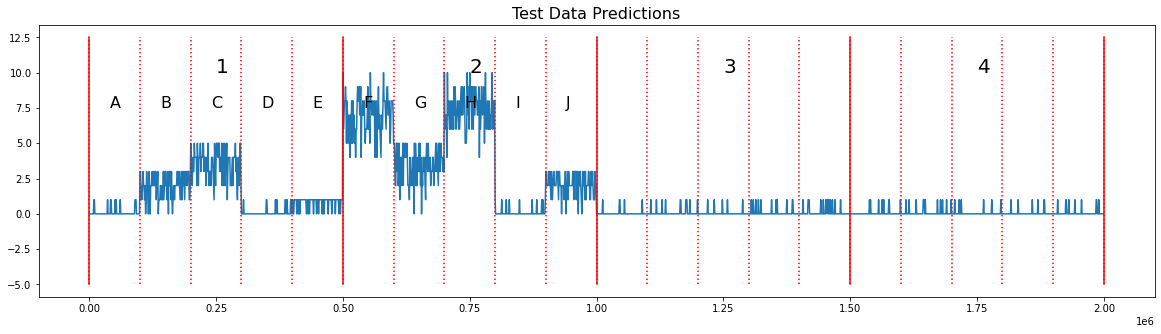

In [11]:
# Sanity check 
# https://www.kaggle.com/cdeotte/one-feature-model-0-930
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,test.shape[0],res),df_subm.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()